# Logistic Regression with UCI Dataset

In [1]:
import os
os.environ["PYTHONWARNINGS"] = "ignore"

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import cupy as cp
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression

from sklearn.preprocessing import LabelEncoder
from ucimlrepo import fetch_ucirepo

import ld

In [2]:
def find_factorization(D):
    factors = []

    # Try to find a factorization with 3 factors first
    for a in range(2, int(D**(1/3)) + 2):
        if D % a == 0:
            bc = D // a
            for b in range(a, int(bc**(1/2)) + 2):
                if bc % b == 0:
                    c = bc // b
                    factors.append((a, b, c))
                    return factors

    # If 3-factor factorization is not found, try 2-factor factorization
    for a in range(2, int(D**(1/2)) + 2):
        if D % a == 0:
            b = D // a
            factors.append((a, b))
            return factors

    return factors

## Basic Logistic Regression

### Dataset

In [3]:
UCI_id = 17
test_size = 0.5

In [4]:
UCI_dataset = fetch_ucirepo(id=UCI_id)

X = np.array(UCI_dataset.data.features)
Y = np.array(LabelEncoder().fit_transform(UCI_dataset.data.targets))

# Print the shape of features and labels
print("Shape of features:", X.shape)
print("Shape of labels:", Y.shape)

# Normalize the input data
# X_mean = np.mean(X, axis=0)
# X_std = np.std(X, axis=0)
# X = normalization(X, X_mean, X_std)

# Find unique labels
unique_labels = np.unique(Y)
print("Unique labels:", unique_labels)

# Create an array of indices
indices = np.arange(len(Y))
np.random.shuffle(indices)

# Use the shuffled indices to randomly select data for training and testing
n_train = int(len(Y) * (1 - test_size))
X_train, Y_train = X[indices[:n_train]], Y[indices[:n_train]]
X_test, Y_test = X[indices[n_train:]], Y[indices[n_train:]]

print("Shape of features:", X_train.shape)

X_train_class = []
Y_train_class = []
for i in unique_labels:
    X_train_class.append(X_train[np.isin(Y_train, i).flatten()])
    Y_train_class.append(Y_train[np.isin(Y_train, i).flatten()])

Shape of features: (569, 30)
Shape of labels: (569,)
Unique labels: [0 1]
Shape of features: (284, 30)


In [5]:
# Feature dimension
D = X_train.shape[1]
D_ = find_factorization(D)[0]
# D_ = (3, 5, 2)
print("Tensor Structure of the Feature:", D_)

Tensor Structure of the Feature: (2, 3, 5)


Accuracy on the test set: 0.9508771929824561


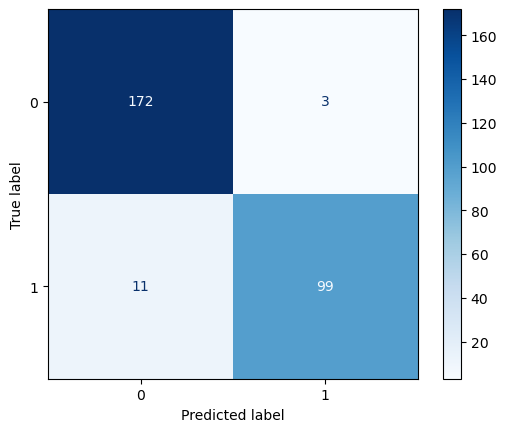

In [6]:
# Train a logistic classifier
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, Y_train)

# Measure the accuracy on the test set
accuracy = clf.score(X_test, Y_test)
print("Accuracy on the test set:", accuracy)

# Optional: Display the confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_pred = clf.predict(X_test)
cm = confusion_matrix(Y_test, y_pred, labels=unique_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=unique_labels)

disp.plot(cmap=plt.cm.Blues)
plt.show()

## Data Generation

### Legendre Decomposition

In [7]:
scaleX_class = []
theta_class = []

B_LD = ld.default_B(D_, 2, cp.get_array_module(X_train[0]))
# B_LD = step_B(D_, (1, 2, 2))

for X_train_per_class in X_train_class:
    scaleX_list = []
    theta_list = []

    for x in X_train_per_class:
        x_tensor = x.reshape(*D_)
        history_kl, history_norm, scaleX, Q, theta = ld.LD(x_tensor, B=B_LD, verbose=False, n_iter=1000, lr=1e-1)
        scaleX_list.append(scaleX)
        theta_list.append(theta)

    scaleX_class.append(scaleX_list)
    theta_class.append(theta_list)

### Fitting and Sampling

In [17]:
from sklearn.neighbors import KernelDensity

def vectorize_tensor(T, B):
    """
    Vectorizes the tensor T by selecting only the indices in B.

    Parameters:
    - T: numpy array of shape (num_samples, ...)
    - B: list of indices to select from each sample

    Returns:
    - V: vectorized representation of T of shape (num_samples, len(B))
    """
    num_samples = T.shape[0]
    V = np.zeros((num_samples, len(B)))
    for i in range(num_samples):
        for j, idx in enumerate(B):
            V[i, j] = T[i, *idx]
    return V

def reconstruct_tensor(V, T_shape, B):
    """
    Reconstructs the tensor T from its vectorized representation V.

    Parameters:
    - V: vectorized representation of T of shape (num_samples, len(B))
    - T_shape: original shape of the tensor T
    - B: list of indices that were used to create the vectorized representation

    Returns:
    - T: reconstructed tensor with the original shape, missing values filled with zero
    """
    num_samples = V.shape[0]
    T = np.zeros(T_shape)
    for i in range(num_samples):
        for j, idx in enumerate(B):
            T[i, *idx] = V[i, j]
    return T

num_new_samples = 300

sampled_theta_class = []

for i in unique_labels:
    reduced_theta = vectorize_tensor(np.array(theta_class[i]), B_LD)

    # Fit a KDE to the theta values
    kde = KernelDensity(kernel='gaussian', bandwidth=0.15).fit(reduced_theta)
    # Sample new data from the KDE
    sampled_reduced_theta = kde.sample(n_samples=num_new_samples)

    sampled_theta = reconstruct_tensor(sampled_reduced_theta, (num_new_samples, *D_), B_LD)

    sampled_theta_class.append(sampled_theta)

#### Construct Submanifold

In [18]:
# Construct the constrained coordinates
B_BP = ld.block_B([1, 1, 1], [2, 3, 2])
# B_BP = B_LD
# Compute every datapoint's eta_hat (served as the linear constraints)
eta_hat_class = []

for i in unique_labels:
    eta_hat_list = []
    for j in range(X_train_class[i].shape[0]):
        x_tensor = X_train_class[i][j].reshape(*D_)
        eps = np.asarray(1.0e-5)
        xp = cp.get_array_module(x_tensor)
        P = (x_tensor + eps) / scaleX_class[i][j]
        eta_hat = ld.get_eta(P, len(D_), xp)
        eta_hat_list.append(eta_hat)
    eta_hat_list = cp.asarray(eta_hat_list)

    eta_hat_class.append(eta_hat_list)

#### Backward Projection

In [19]:
def find_closest_datapoint(input_point, training_data):
    min_divergence = float('inf')
    closest_index = -1
    input_prob = ld.get_Q(input_point)
    for i, data_point in enumerate(training_data):
        data_prob = ld.get_Q(data_point)
        kl_div = ld.kl(input_prob, data_prob)
        if kl_div < min_divergence:
            min_divergence = kl_div
            closest_index = i
    return closest_index

sampled_P_BP_class = []
sampled_theta_BP_class = []
X_recons_class = []

for i in unique_labels:
    sampled_P_list_BP = []
    sampled_theta_list_BP = []
    X_recons_list = []

    for j in range(num_new_samples):
        k = find_closest_datapoint(sampled_theta_class[i][j], np.array(theta_class[i]))

        history_kl, history_norm, P, theta = ld.BP(sampled_theta_class[i][j], (X_train[k].reshape(*D_) + eps) / np.sum(X_train[k].reshape(*D_) + eps), eta_hat_class[i][k], scaleX_class[i][k], B=B_BP, verbose=False, n_iter=1000, lr=1e-2, exit_abs=True)
        sampled_P_list_BP.append(P)
        sampled_theta_list_BP.append(theta)

        X_recons = (P).astype(np.int32).reshape(-1)
        X_recons_list.append(X_recons)

    sampled_P_BP_class.append(sampled_P_list_BP)
    sampled_theta_BP_class.append(sampled_theta_list_BP)
    X_recons_class.append(np.array(X_recons_list))

## Generated Data Quality

### Trained on Generated Data

Accuracy on the test set: 0.9122807017543859


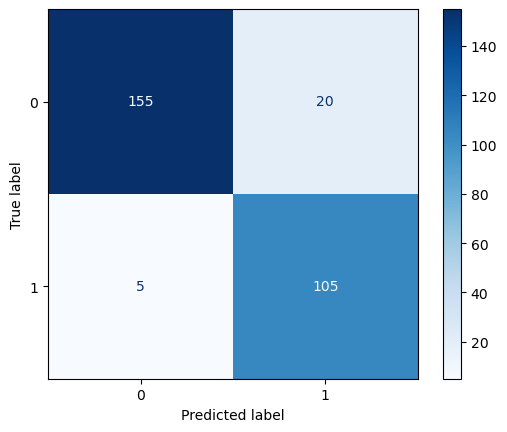

In [20]:
# Initialize lists to hold new samples
X_train_list_new = []
Y_train_list_new = []

for i in unique_labels:
    X_train_list_new.append(X_recons_class[i])
    Y_train_list_new.append([i] * num_new_samples)

# Convert lists to numpy arrays
X_train_new = np.concatenate(X_train_list_new, axis=0)
Y_train_new = np.concatenate(Y_train_list_new, axis=0)

# Train a logistic classifier
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train_new, Y_train_new)

# Measure the accuracy on the test set
accuracy = clf.score(X_test, Y_test)
print("Accuracy on the test set:", accuracy)

# Optional: Display the confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_pred = clf.predict(X_test)
cm = confusion_matrix(Y_test, y_pred, labels=unique_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=unique_labels)

disp.plot(cmap=plt.cm.Blues)
plt.show()

### Visualization

#### PCA

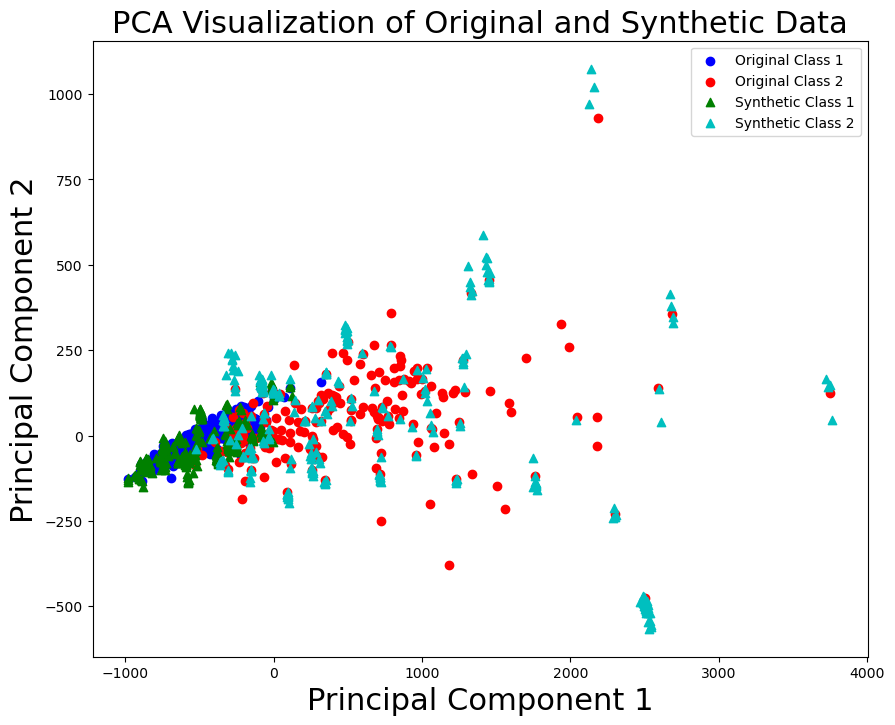

In [23]:
from sklearn.decomposition import PCA

# Generate original data (example)
X_original, Y_original = X, Y

# Generate synthetic data for class 1 and class 2 (example)
X_synthetic, Y_synthetic = X_train_new, Y_train_new

# Step 1: Perform PCA for dimensionality reduction on original data
pca = PCA(n_components=2)
X_pca = pca.fit_transform(np.concatenate((X_original, X_synthetic)))

# Step 3: Plotting
plt.figure(figsize=(10, 8))

# Define the colors for the plot
colors = ['b', 'r', 'g', 'c', 'm', 'y', 'k']

# Plot original data
for i, class_label in enumerate(unique_labels):
    plt.scatter(X_pca[:X_original.shape[0]][Y_original == class_label, 0],
                X_pca[:X_original.shape[0]][Y_original == class_label, 1],
                color=colors[i % len(colors)],
                marker='o',
                label=f'Original Class {class_label + 1}')

# Plot synthetic data
for i, class_label in enumerate(unique_labels):
    plt.scatter(X_pca[X_original.shape[0]:][Y_synthetic == class_label, 0],
                X_pca[X_original.shape[0]:][Y_synthetic == class_label, 1],
                color=colors[i % len(colors) + len(unique_labels)],
                marker='^',
                label=f'Synthetic Class {class_label + 1}')

plt.title('PCA Visualization of Original and Synthetic Data', fontsize=22)
plt.xlabel('Principal Component 1', fontsize=22)
plt.ylabel('Principal Component 2', fontsize=22)
plt.legend()
plt.show()


#### t-SNE

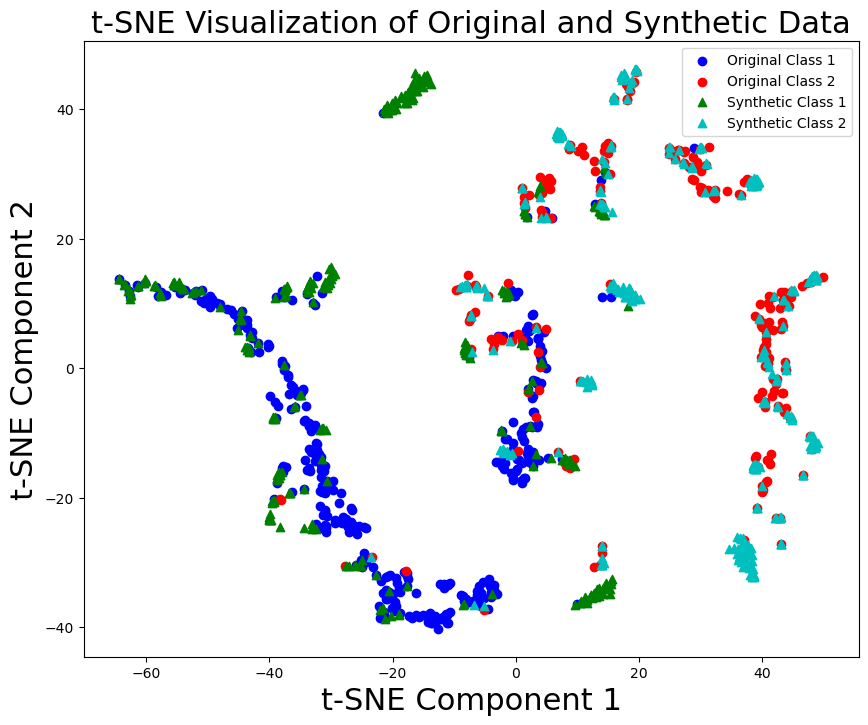

In [24]:
from sklearn.manifold import TSNE

# Generate original data (example)
X_original, Y_original = X, Y

# Generate synthetic data for class 1 and class 2 (example)
X_synthetic, Y_synthetic = X_train_new, Y_train_new

# Combine the original and synthetic data
X_combined = np.concatenate((X_original, X_synthetic))

# Step 1: Perform t-SNE for dimensionality reduction on combined data
tsne = TSNE(n_components=2, random_state=42, perplexity=20)
X_tsne = tsne.fit_transform(X_combined)

# Define the colors for the plot
colors = ['b', 'r', 'g', 'c', 'm', 'y', 'k']

# Get unique labels
unique_labels = np.unique(np.concatenate((Y_original, Y_synthetic)))

# Step 3: Plotting
plt.figure(figsize=(10, 8))

# Plot original data
for i, class_label in enumerate(unique_labels):
    plt.scatter(X_tsne[:X_original.shape[0]][Y_original == class_label, 0],
                X_tsne[:X_original.shape[0]][Y_original == class_label, 1],
                color=colors[i % len(colors)],
                marker='o',
                label=f'Original Class {class_label + 1}')

# Plot synthetic data
for i, class_label in enumerate(unique_labels):
    plt.scatter(X_tsne[X_original.shape[0]:][Y_synthetic == class_label, 0],
                X_tsne[X_original.shape[0]:][Y_synthetic == class_label, 1],
                color=colors[i % len(colors) + len(unique_labels)],
                marker='^',
                label=f'Synthetic Class {class_label + 1}')

plt.title('t-SNE Visualization of Original and Synthetic Data', fontsize=22)
plt.xlabel('t-SNE Component 1', fontsize=22)
plt.ylabel('t-SNE Component 2', fontsize=22)
plt.legend()
plt.show()